In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

2 - Overview of the Problem set Problem Statement: You are given a dataset ("data.h5") containing:

a training set of m_train images labeled as cat (y=1) or non-cat (y=0) a test set of m_test images labeled as cat or non-cat each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px). You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [2]:
def load_dataset():
    with h5py.File('F:/chirps/catvnoncat/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('F:/chirps/catvnoncat/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with trainset_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

y = [0], it's a 'non-cat' picture.


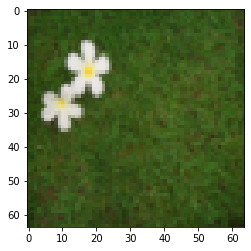

In [4]:
# Example of a picture
index = 6
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

In [5]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [32]:
nx = train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3]
m = train_set_x_orig.shape[0]

In [33]:
mean_train = np.mean(train_set_x_orig, axis = 0, keepdims = True)
std_train = np.std(train_set_x_orig, axis = 0, keepdims = True)
train_set_x = (train_set_x_orig - mean_train) / std_train
test_set_x = (test_set_x_orig - mean_train) / std_train

In [34]:
train_set_x = train_set_x.reshape(nx,m)
test_set_x = test_set_x.reshape(nx,50)

In [37]:
##Defining Activation functions 
def tanh(z):
    temp = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    return temp;

def sigmoid(z):
    temp = 1/(1+np.exp(-z))
    return temp;

def leaky_relu(z):
    temp = (0.01*z)*(z<0)+z*(z>=0)
    return temp

def relu(z):
    temp = np.maximum(0,z)
    return temp

In [38]:
## Derivatives of Activation function
def grad_tanh(z):
    temp = 1 - tanh(z)*tanh(z)
    return temp

def grad_sigmoid(z):
    temp = sigmoid(z)*(1-sigmoid(z))
    return temp

def grad_leaky_relu(z):
    temp = 0.01*(z<0)+1*(z>=0)
    return temp

def grad_relu(z):
    temp = 0*(z<0)+1*(z>=0)
    return temp

In [39]:
## Initialize parameters as total number of layers
def initialize_param(L,nx,m):
    x = []
    y = [0]
    x.append(nx)
    for i in range(L):
        x.append(input())
        y.append(input())
    return L, x, m, y


In [40]:
def parameters(L,x):
    w = [0]
    b = [0]
    for i in range(1,L+1):
        temp1 = np.random.randn(int(x[i-1]),int(x[i]))*0.01
        w.append(temp1)
        temp2 = np.zeros((int(x[i]),1))
        b.append(temp2)
        
    return w,b

In [41]:
##Forward Propagation step
def fwd_prop(L, w, b, training_x, y):
    z = [0]
    a = []
    a.append(training_x)
    for i in  range(1,L+1):
        temp1 = np.dot(w[i].T,a[i-1])+b[i]
        z.append(temp1)
        if(i!=L):
            temp3 = relu(z[i])
            
        
        else: 
            temp3 = sigmoid(z[i])
        a.append(temp3)
        
    return a,z

In [42]:
## Calculating cost funtion
def cost_fn(Y, a, m, L):
    
    temp =  -1*(Y*np.log(a[L])+(1-Y)*np.log(1-a[L]))
    cost = np.sum(temp)/m
    
    return cost

In [43]:
##backpropagartion step
def back_prop(L, x, m, w, b, a, z, y, Y_train):
    dz = [0]
    dw = [0]
    db = [0]
    
    for i in range(1,L+1):
        dz.append(np.zeros((z[i].shape)))
        dw.append(np.zeros((w[i].shape)))
        db.append(np.zeros((b[i].shape)))
        
    dz[L] = a[L] - Y_train
   
    for i in range(L,0,-1):
       
            
        dz[i-1] = np.dot(w[i], dz[i]) * grad_relu(z[i-1])
                
        dw[i] = (1/m)*np.dot(a[i-1], dz[i].T)
        db[i] = (1/m)*np.sum(dz[i], axis=1, keepdims=True)
        
        assert(dw[i].shape == w[i].shape)
        assert(db[i].shape == b[i].shape)
    return dz, dw, db

In [44]:
## updating the calculated parameters
##here alpha = learning rate
def update_param(w, b, dw, db, L, alpha):
    
    for i in  range(1,L+1):
        w[i] = w[i] - alpha * dw[i]
        b[i] = b[i] - alpha * db[i]
        
    return w, b

In [47]:
## defining the model to run
def model(X_train, Y_train, L, alpha, num_iterations):
    L, x, m, y = initialize_param(3, X_train.shape[0], X_train.shape[1])
    w, b = parameters(L,x)
    
    for i in range(num_iterations):
        a, z = fwd_prop(L, w, b , X_train, y)
        cost = cost_fn(Y_train, a, m, L)
        dz, dw, db = back_prop(L, x, m, w, b, a, z, y, Y_train)
        w, b = update_param(w, b, dw, db, L, alpha)
        ##if(i%100==0):
            ##print("value of cost with",i, " iternation: ", cost)
        
       
    return w, b, cost

In [48]:
l_rate = [0.002]
cost_f = []
for i in range(12):
    w, b, cost = model(train_set_x, train_set_y, 3, l_rate[i], 3000)
    print("Cost with learning rate= ", l_rate[i], " = ", cost )
    cost_f.append(cost)
    temp = l_rate[i]*2
    l_rate.append(temp)

5
r
3
r
1
s
Cost with learning rate=  0.002  =  0.646774021239727
5
t
3
f
1
d
Cost with learning rate=  0.004  =  0.6441511861667162
5
r
3
r
1
s
Cost with learning rate=  0.008  =  0.6120112834331415
5
r
3
r
1
s
Cost with learning rate=  0.016  =  0.24007767476145192
5
r
3
r
1
s
Cost with learning rate=  0.032  =  0.19989683447674134
5
r
3
r
1
s
Cost with learning rate=  0.064  =  0.26490070636642454
5
r
3
r
1
s
Cost with learning rate=  0.128  =  0.6424508972746097
5
r
3
r
1
s
Cost with learning rate=  0.256  =  0.427532549622923
5
r
3
r
1
s
Cost with learning rate=  0.512  =  0.6439737380528058
5
r
3
r
1
s
Cost with learning rate=  1.024  =  0.6439737380528056
5
r
3
r
1
s
Cost with learning rate=  2.048  =  0.6439737380528058
5
r
3
t
1
s
Cost with learning rate=  4.096  =  0.6439737380528059


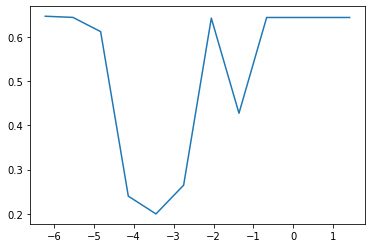

In [54]:
plt.plot(np.log(l_rate[0:12]), cost_f)

In [412]:
l_rate = [0.1]
cost_f = []
for i in range(8):
    w, b, cost = model(train_set_x, train_set_y, 3, l_rate[i], 2500)
    print("Cost with learning rate= ", l_rate[i], " = ", cost )
    cost_f.append(cost)
    temp = l_rate[i]+0.01
    l_rate.append(temp)

5
r
3
r
1
s
Cost with learning rate=  0.1  =  0.6439914363552786
5
r
3
r
1
s
Cost with learning rate=  0.11  =  0.6439737380528059
5
r
3
r
1
s
Cost with learning rate=  0.12  =  0.643973738052806
s
s
s
s
s
s


ValueError: invalid literal for int() with base 10: 's'

In [331]:
l_rate = [0.0001]
cost_f = []
for i in range(12):
    w, b, cost = model(train_set_x, train_set_y, 2, l_rate[i], 3000)
    print("Cost with learning rate= ", l_rate[i], " = ", cost )
    cost_f.append(cost)
    temp = l_rate[i]*2
    l_rate.append(temp)

7
1
1
1
Cost with learning rate=  0.0001  =  0.6586515649312624
7
1
1
1
Cost with learning rate=  0.0002  =  0.638571756539597
7
r
1
s
Cost with learning rate=  0.0004  =  0.6308372991490325
7
1
1
1
Cost with learning rate=  0.0008  =  0.6053997469274883
7
1
1
1
Cost with learning rate=  0.0016  =  0.5800697810337028
7
1
1
1
Cost with learning rate=  0.0032  =  0.45557292464478766
7
1
1
1
Cost with learning rate=  0.0064  =  0.4766757620460904
7
1
1
1
Cost with learning rate=  0.0128  =  0.21081068948441797
7
1
1
1
Cost with learning rate=  0.0256  =  0.3172871302565884
7
1
1
1
Cost with learning rate=  0.0512  =  0.34925962816463446
7
1
1
1
Cost with learning rate=  0.1024  =  0.6439737380528058
7
1
1
1
Cost with learning rate=  0.2048  =  0.6439737380528059


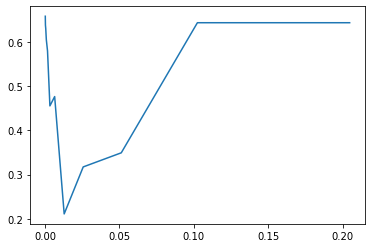

In [337]:
plt.plot(l_rate[0:12], cost_f)

In [339]:
l_rate = [0.01]
cost_f = []
for i in range(5):
    w, b, cost = model(train_set_x, train_set_y, 2, l_rate[i], 3000)
    print("Cost with learning rate= ", l_rate[i], " = ", cost )
    cost_f.append(cost)
    temp = l_rate[i]+0.002
    l_rate.append(temp)

7
1
1
1
Cost with learning rate=  0.01  =  0.19378081179582174
7
1
1
1
Cost with learning rate=  0.012  =  0.16433064697752886
7
1
1
1
Cost with learning rate=  0.014  =  0.5789041707593529
7
1
1
1
Cost with learning rate=  0.016  =  0.17178771213885868
7
1
1
1
Cost with learning rate=  0.018000000000000002  =  0.1673031173132758


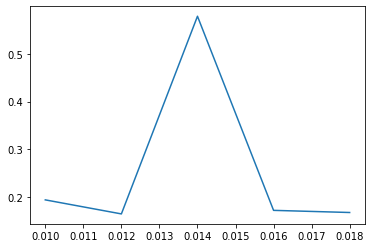

In [341]:
plt.plot(l_rate[0:5], cost_f)

In [407]:
w, b, cost = model(train_set_x, train_set_y, 2, 0.0131, 3000)

7
1
1
1


In [397]:
cost

0.2118483411132191

In [398]:
## Defining a prediction fucntion

def predict(w ,b ,X, L):
    
    a, z = fwd_prop(L, w, b, X, y)
    y_pred = 0*(a[L]<=0.5)+1*(a[L]>0.5)
    
    return y_pred

In [399]:
y_pred = predict(w, b, train_set_x)
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred - train_set_y)) * 100))

train accuracy: 93.30143540669856 %


In [400]:
y_pred_test = predict(w, b, test_set_x)
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - test_set_y)) * 100))

train accuracy: 42.00000000000001 %


In [403]:
accuracy_train.append("train accuracy 2 layers iter=3000 alpha = 0.0129:{} %".format(100 - np.mean(np.abs(y_pred - train_set_y)) * 100))

In [404]:
accuracy_test.append("test accuracy 2 layers iter=3000 alpha = 0.0129: {} %".format(100 - np.mean(np.abs(y_pred_test - test_set_y)) * 100))

In [405]:
accuracy_train

['train accuracy 2 layers iter=3000 alpha = 0.0016:97.60765550239235 %',
 'train accuracy 2 layers iter=3000 alpha = 0.0016:90.43062200956938 %',
 'train accuracy 2 layers iter=3000 alpha = 0.019:97.12918660287082 %',
 'train accuracy 2 layers iter=3000 alpha = 0.019:93.30143540669856 %',
 'train accuracy 2 layers iter=3000 alpha = 0.0129:93.30143540669856 %']

In [406]:
accuracy_test

['test accuracy 2 layers iter=3000 alpha = 0.0016: 64.0 %',
 'test accuracy 2 layers iter=3000 alpha = 0.0016: 34.0 %',
 'test accuracy 2 layers iter=3000 alpha = 0.019: 48.0 %',
 'test accuracy 2 layers iter=3000 alpha = 0.019: 42.00000000000001 %',
 'test accuracy 2 layers iter=3000 alpha = 0.0129: 42.00000000000001 %']

In [ ]:
##backpropagartion step
def back_prop(L, x, m, w, b, a, z, y):
    dz = [0]
    dw = [0]
    db = [0]
    
    for i in range(1,L+1):
        dz.append(np.zeros((z[i].shape)))
        dw.append(np.zeros((w[i].shape)))
        db.append(np.zeros((b[i].shape)))
        
    dz[L] = a[L] - train_set_y
    for i in range(L,0,-1):
        if(i>1):
            
            dz[i-1] = np.dot(w[i], dz[i]) * grad_relu(z[i-1])
                
        dw[i] = (1/m)*np.dot(a[i-1], dz[i].T)
        db[i] = (1/m)*np.sum(dz[i], axis=1, keepdims=True)
        
        assert(dw[i].shape == w[i].shape)
        assert(db[i].shape == b[i].shape)
    return dz, dw, db

In [332]:
for i in range(L,0,-1):
        if(i>1):
            if(y[i]=='sigmoid'):
                dz[i-1] = np.dot(w[i], dz[i]) * grad_sigmoid(z[i-1])
                
            if(y[i]=='tanh'):
                dz[i-1] = np.dot(w[i], dz[i]) * grad_tanh(z[i-1])
                
            if(y[i]=='relu'):
                dz[i-1] = np.dot(w[i], dz[i]) * grad_relu(z[i-1])
                
            else:
                dz[i-1] = np.dot(w[i], dz[i]) * grad_leaky_relu(z[i-1])
                
        dw[i] = (1/m)*np.dot(a[i-1], dz[i].T)
        db[i] = (1/m)*np.sum(dz[i], axis=1, keepdims=True)
        

0.8336546070121552

In [ ]:
L, x, m = initialize_param(4, train_set_x.shape[0], train_set_x.shape[1])
w, b = parameters(L,x)
a, z = fwd_prop(L, w, b , train_set_x)
cost = cost_fn(train_set_y, a, m)
dz, dw, db = back_prop(L, x, m, w, b, a, z)

In [ ]:
##Parameter no of hidden layer units 
def parameters(nh,nx):
    w1 = np.random.randn(nh,nx)*0.001
    b1 = np.zeros((nh,1))

    w2 = np.random.randn(nh,1)*0.001
    b2 = 0
    return w1,b1,w2,b2